import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks


def butter_lowpass_filter(data, cutoff=5, fs=100, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Assure-toi d'avoir la fonction de filtrage définie
def butter_lowpass_filter(data, cutoff=5, fs=50, order=4):
    from scipy.signal import butter, filtfilt
    b, a = butter(order, cutoff / (0.5 * fs), btype='low')
    return filtfilt(b, a, data)

def process_curl(file_path, label):
    df = None
    last_error = None

    # Essayer différents encodages
    for enc in ["utf-8", "latin1", "cp1252", "ISO-8859-1", "utf-16"]:
        try:
            df = pd.read_csv(file_path, encoding=enc, sep=None, engine="python")
            print(f"Fichier chargé avec encodage : {enc}")
            break
        except Exception as e:
            last_error = e
            continue

    if df is None:
        raise last_error  # impossible de lire le fichier

    # Renommer colonnes (ajuste si ton fichier a des en-têtes différents)
    df.columns = ["Temps", "ax", "ay", "az"]

    # Filtrage
    df["ax_f"] = butter_lowpass_filter(df["ax"])
    df["ay_f"] = butter_lowpass_filter(df["ay"])
    df["az_f"] = butter_lowpass_filter(df["az"])

    # Magnitude de l'accélération
    df["acc_mag"] = np.sqrt(df["ax_f"]**2 + df["ay_f"]**2 + df["az_f"]**2)

    # Détection répétitions
    peaks, _ = find_peaks(df["acc_mag"], height=np.mean(df["acc_mag"]))
    df["rep"] = 0
    df.loc[peaks, "rep"] = 1
    df["rep"] = df["rep"].cumsum()

    # Vitesse instantanée
    df["speed"] = np.gradient(df["acc_mag"], df["Temps"])

    # Métriques globales
    amplitude = df["acc_mag"].max() - df["acc_mag"].min()
    stabilite = df["acc_mag"].std()
    vitesse_moy = abs(df["speed"]).mean()
    ascent = df["speed"][df["speed"] > 0].mean()
    descent = abs(df["speed"][df["speed"] < 0].mean())
    symetrie = 1 - abs(ascent - descent)/max(ascent, descent)

    # Métriques rep-par-rep
    amplitudes_rep = df.groupby("rep")["acc_mag"].max() - df.groupby("rep")["acc_mag"].min()
    amplitude_mean_rep = amplitudes_rep.mean()
    amplitude_std_rep = amplitudes_rep.std()

    # Calcul du jerk
    df["jerk"] = np.gradient(df["acc_mag"])
    jerk_mean = df["jerk"].abs().mean()

    metrics = {
        "label": label,
        "reps": len(peaks),
        "amplitude": amplitude,
        "stabilite": stabilite,
        "vitesse_moy": vitesse_moy,
        "symetrie": symetrie,
        "amplitude_mean_rep": amplitude_mean_rep,
        "amplitude_std_rep": amplitude_std_rep,
        "jerk_mean": jerk_mean,
        "rep_amplitudes_series": amplitudes_rep
    }

    return df, metrics, peaks


In [9]:
file_s = r"C:\Analyse de données\CWA-DATA Achraf crossbody.csv"
file_ns = r"C:\Analyse de données\CWA-DATA nico crossboby.csv"

df_s, metrics_s, peaks_s = process_curl(file_s, "Sportif")
df_ns, metrics_ns, peaks_ns = process_curl(file_ns, "Non-Sportif")


with open(file_s, "rb") as f:
    raw = f.read(300)
    print(raw)


Fichier chargé avec encodage : utf-8
Fichier chargé avec encodage : utf-8
b'0.0000,0.578125,0.734375,-0.296875\r\n0.0100,0.515625,0.812500,-0.203125\r\n0.0200,0.656250,0.937500,-0.187500\r\n0.0300,0.750000,1.000000,-0.125000\r\n0.0400,0.781250,0.984375,-0.062500\r\n0.0500,0.765625,0.953125,0.078125\r\n0.0600,0.703125,0.921875,0.140625\r\n0.0700,0.718750,0.906250,0.109375\r\n0.0800,0.734375'


In [10]:
df_compare = pd.DataFrame([metrics_s, metrics_ns])
df_compare.set_index("label", inplace=True)

df_compare["amplitude_CV"] = df_compare["amplitude_std_rep"] / df_compare["amplitude_mean_rep"]
print(df_compare)

             reps  amplitude  stabilite  vitesse_moy  symetrie  \
label                                                            
Sportif       262   1.442808   0.185486     1.433442  0.972879   
Non-Sportif   189   1.604588   0.126564     1.076349  0.983962   

             amplitude_mean_rep  amplitude_std_rep  jerk_mean  \
label                                                           
Sportif                0.247819           0.264312   0.014536   
Non-Sportif            0.195003           0.217190   0.010905   

                                         rep_amplitudes_series  amplitude_CV  
label                                                                         
Sportif      rep
0      0.228927
1      0.375148
2      0.5...      1.066553  
Non-Sportif  rep
0      0.100425
1      0.123004
2      0.0...      1.113778  


In [11]:
# Ajout amplitude_CV dans les dictionnaires pour éviter KeyError
metrics_s["amplitude_CV"] = metrics_s["amplitude_std_rep"] / metrics_s["amplitude_mean_rep"]
metrics_ns["amplitude_CV"] = metrics_ns["amplitude_std_rep"] / metrics_ns["amplitude_mean_rep"]


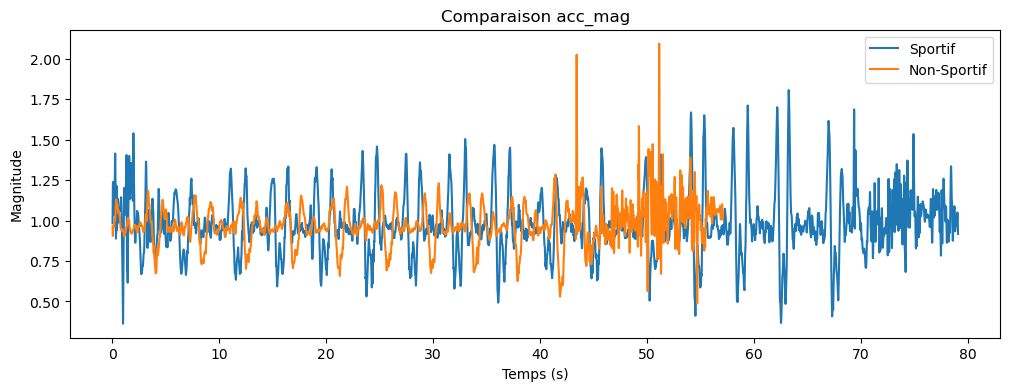

In [12]:
plt.figure(figsize=(12,4))
plt.plot(df_s["Temps"], df_s["acc_mag"], label="Sportif")
plt.plot(df_ns["Temps"], df_ns["acc_mag"], label="Non-Sportif")
plt.legend()
plt.title("Comparaison acc_mag")
plt.xlabel("Temps (s)")
plt.ylabel("Magnitude")
plt.show()


C:\Users\SCD UM\AppData\Local\Temp\ipykernel_6076\3188918235.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([metrics_s["rep_amplitudes_series"], metrics_ns["rep_amplitudes_series"]],


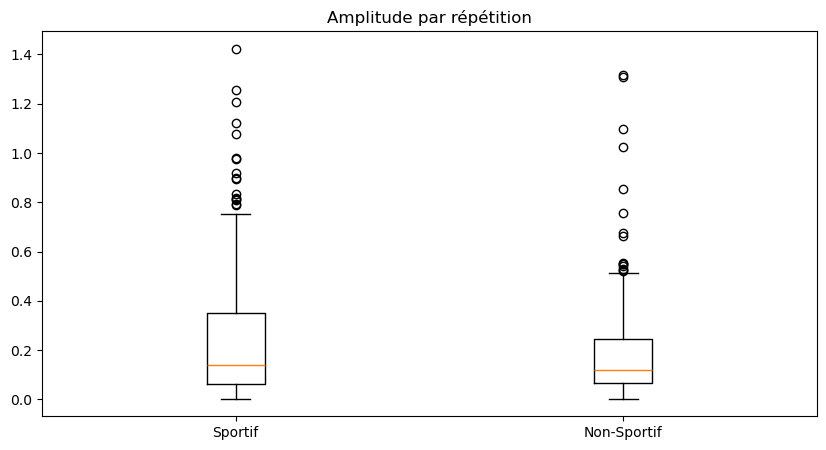

In [13]:
plt.figure(figsize=(10,5))
plt.boxplot([metrics_s["rep_amplitudes_series"], metrics_ns["rep_amplitudes_series"]],
            labels=["Sportif", "Non-Sportif"])
plt.title("Amplitude par répétition")
plt.show()


In [14]:
print("\n===== Résumé Sportif vs Non-Sportif =====")

if metrics_s["amplitude_CV"] < metrics_ns["amplitude_CV"]:
    print("✔ Le sportif a une amplitude plus régulière.")
else:
    print("✔ Le non-sportif est plus régulier en amplitude.")

if metrics_s["stabilite"] < metrics_ns["stabilite"]:
    print("✔ Le sportif a un geste plus stable.")
else:
    print("✔ Le non-sportif a un geste plus stable.")

if metrics_s["vitesse_moy"] < metrics_ns["vitesse_moy"]:
    print("✔ Le sportif contrôle mieux sa vitesse (moins d’à-coups).")
else:
    print("✔ Le non-sportif utilise une vitesse plus faible ou plus variable.")

if metrics_s["jerk_mean"] < metrics_ns["jerk_mean"]:
    print("✔ Le sportif a un mouvement techniquement plus propre (sans triche).")
else:
    print("✘ Le non-sportif a moins de jerk → mouvement plus propre.")
    
print(f"Jerk moyen Sportif : {metrics_s['jerk_mean']:.4f}")
print(f"Jerk moyen Non-sportif : {metrics_ns['jerk_mean']:.4f}")



===== Résumé Sportif vs Non-Sportif =====
✔ Le sportif a une amplitude plus régulière.
✔ Le non-sportif a un geste plus stable.
✔ Le non-sportif utilise une vitesse plus faible ou plus variable.
✘ Le non-sportif a moins de jerk → mouvement plus propre.
Jerk moyen Sportif : 0.0145
Jerk moyen Non-sportif : 0.0109
